# Instalare pachete necesare

In [ ]:
!pip install pyspark

In [ ]:
import pandas as pd
import json
import requests
import time
import matplotlib.pyplot as plt
from google.colab import drive
drive.mount('/content/drive')
from pyspark import SparkConf
from pyspark.sql import SparkSession
from pyspark.sql.functions import count, avg, max_by, max

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


# Creare foldere pentru stocarea graficelor

In [ ]:
# Folderul unde stocam graficele care ne arata evolutia scorului de popularitate pentru fiecare gen muzical de-a lungul timpului
!mkdir "/content/Grafice_evolutie_popularitate_dupa_gen"

# Folderul unde stocam graficele care ne arata numarul de piese ascultate dupa gen pentru fiecare an
!mkdir "/content/Grafice_numar_piese_dupa_gen_dupa_an_lansare"

mkdir: cannot create directory ‘/content/Grafice_evolutie_popularitate_dupa_gen’: File exists
mkdir: cannot create directory ‘/content/Grafice_numar_piese_dupa_gen_dupa_an_lansare’: File exists


# Extragere set de date cu doua call Spotify APIs, unul pentru preluarea genurilor muzicale din Romania si unul pentru preluarea pieselor pentru fiecare gen muzical din Romania

## API call pentru obtinerea token-ului

In [ ]:
def get_token():
  url="https://accounts.spotify.com/api/token"
  header={
      "Content-Type": "application/x-www-form-urlencoded"
      }
  data="grant_type=client_credentials&client_id=your_client_id&client_secret=your_client_secret"
  request=requests.post(url=url,headers=header,data=data)
  response=request.json()
  token=response["access_token"]
  return token

In [ ]:
my_token=get_token()

## API call pentru obtinerea genurilor muzicale ascultate de publicul din Romania

In [ ]:
url_genres="https://api.spotify.com/v1/recommendations/available-genre-seeds"
header={
  "Authorization": "Bearer  "+my_token
}
response_genres=requests.get(url=url_genres,headers=header)

In [ ]:
genres_data=response_genres.json()

## Stocarea genurilor muzicale intr-o lista si adaugarea textului "genre:"denumire_gen"" pentru fiecare gen muzical

In [ ]:
genres=genres_data["genres"]

In [ ]:
genres

['acoustic',
 'afrobeat',
 'alt-rock',
 'alternative',
 'ambient',
 'anime',
 'black-metal',
 'bluegrass',
 'blues',
 'bossanova',
 'brazil',
 'breakbeat',
 'british',
 'cantopop',
 'chicago-house',
 'children',
 'chill',
 'classical',
 'club',
 'comedy',
 'country',
 'dance',
 'dancehall',
 'death-metal',
 'deep-house',
 'detroit-techno',
 'disco',
 'disney',
 'drum-and-bass',
 'dub',
 'dubstep',
 'edm',
 'electro',
 'electronic',
 'emo',
 'folk',
 'forro',
 'french',
 'funk',
 'garage',
 'german',
 'gospel',
 'goth',
 'grindcore',
 'groove',
 'grunge',
 'guitar',
 'happy',
 'hard-rock',
 'hardcore',
 'hardstyle',
 'heavy-metal',
 'hip-hop',
 'holidays',
 'honky-tonk',
 'house',
 'idm',
 'indian',
 'indie',
 'indie-pop',
 'industrial',
 'iranian',
 'j-dance',
 'j-idol',
 'j-pop',
 'j-rock',
 'jazz',
 'k-pop',
 'kids',
 'latin',
 'latino',
 'malay',
 'mandopop',
 'metal',
 'metal-misc',
 'metalcore',
 'minimal-techno',
 'movies',
 'mpb',
 'new-age',
 'new-release',
 'opera',
 'pagode',

In [ ]:
query_list=['genre:"'+genre+'"' for genre in genres]

In [ ]:
query_list

['genre:"acoustic"',
 'genre:"afrobeat"',
 'genre:"alt-rock"',
 'genre:"alternative"',
 'genre:"ambient"',
 'genre:"anime"',
 'genre:"black-metal"',
 'genre:"bluegrass"',
 'genre:"blues"',
 'genre:"bossanova"',
 'genre:"brazil"',
 'genre:"breakbeat"',
 'genre:"british"',
 'genre:"cantopop"',
 'genre:"chicago-house"',
 'genre:"children"',
 'genre:"chill"',
 'genre:"classical"',
 'genre:"club"',
 'genre:"comedy"',
 'genre:"country"',
 'genre:"dance"',
 'genre:"dancehall"',
 'genre:"death-metal"',
 'genre:"deep-house"',
 'genre:"detroit-techno"',
 'genre:"disco"',
 'genre:"disney"',
 'genre:"drum-and-bass"',
 'genre:"dub"',
 'genre:"dubstep"',
 'genre:"edm"',
 'genre:"electro"',
 'genre:"electronic"',
 'genre:"emo"',
 'genre:"folk"',
 'genre:"forro"',
 'genre:"french"',
 'genre:"funk"',
 'genre:"garage"',
 'genre:"german"',
 'genre:"gospel"',
 'genre:"goth"',
 'genre:"grindcore"',
 'genre:"groove"',
 'genre:"grunge"',
 'genre:"guitar"',
 'genre:"happy"',
 'genre:"hard-rock"',
 'genre:"har

## API call pentru extragerea detaliilor despre piese pentru fiecare gen muzical si stocarea acestora intr-un DataFrame

In [ ]:
def get_tracks_after_genre_query(query):
    url_tracks="https://api.spotify.com/v1/search?q="+query+"&type=track&market=RO&limit=50"
    print("url_tracks: "+url_tracks)
    header={
        "Authorization": "Bearer  "+my_token
        }
    response=requests.get(url=url_tracks,headers=header)
    if response.status_code==200:
      tracks_data=response.json()
      tracks=tracks_data["tracks"]["items"]
      return tracks
    else:
      print("Error during api call. Status: "+str(response.status_code))
      return None

In [ ]:
def create_df(query_list):
  data={
      'Track id':[],
      'Track name':[],
      'Artist name':[],
      'Popularity score':[],
      'Release year':[],
      'Genre':[]
  }
  for query in query_list:
    query=query.replace(" ","+").replace(":","%3A").replace('"',"%22").replace("&","%26")
    tracks=get_tracks_after_genre_query(query)
    if tracks is None:
      print("Error during api call")
    else:
      tracks
      for track in tracks:
        data['Track id'].append(track['id'])
        data['Track name'].append(track['name'])
        data['Artist name'].append(track['artists'][0]['name'])
        data['Popularity score'].append(track['popularity'])
        data['Release year'].append(track['album']['release_date'][:4])
        data['Genre'].append(query[5:].replace("%22","").replace("%3A","").replace("+"," ").replace("%26","&"))

      time.sleep(3)

  df=pd.DataFrame(data)
  return df

In [ ]:
df_Spotify=create_df(query_list=query_list)

url_tracks: https://api.spotify.com/v1/search?q=genre%3A%22acoustic%22&type=track&market=RO&limit=50
url_tracks: https://api.spotify.com/v1/search?q=genre%3A%22afrobeat%22&type=track&market=RO&limit=50
url_tracks: https://api.spotify.com/v1/search?q=genre%3A%22alt-rock%22&type=track&market=RO&limit=50
url_tracks: https://api.spotify.com/v1/search?q=genre%3A%22alternative%22&type=track&market=RO&limit=50
url_tracks: https://api.spotify.com/v1/search?q=genre%3A%22ambient%22&type=track&market=RO&limit=50
url_tracks: https://api.spotify.com/v1/search?q=genre%3A%22anime%22&type=track&market=RO&limit=50
url_tracks: https://api.spotify.com/v1/search?q=genre%3A%22black-metal%22&type=track&market=RO&limit=50
url_tracks: https://api.spotify.com/v1/search?q=genre%3A%22bluegrass%22&type=track&market=RO&limit=50
url_tracks: https://api.spotify.com/v1/search?q=genre%3A%22blues%22&type=track&market=RO&limit=50
url_tracks: https://api.spotify.com/v1/search?q=genre%3A%22bossanova%22&type=track&market=R

In [ ]:
df_Spotify

,Track id,Track name,Artist name,Popularity score,Release year,Genre
0,5vjLSffimiIP26QG5WcN2K,Hold On,Chord Overstreet,82,2017,acoustic
1,3S0OXQeoh0w6AY8WQVckRW,I'm Yours,Jason Mraz,82,2008,acoustic
2,1HMQmOWrkieKYWlFsjUP3D,Bloom - Bonus Track,The Paper Kites,79,2013,acoustic
3,4E6cwWJWZw2zWf7VFbH7wf,Love Song,Sara Bareilles,74,2007,acoustic
4,1EzrEOXmMH3G43AXT1y7pA,I'm Yours,Jason Mraz,79,2008,acoustic
...,...,...,...,...,...,...
5645,5j4EazAPhtFyHhwNpbNzEx,Old Church Basement (feat. Dante Bowe),Elevation Worship,58,2021,world-music
5646,4HIfV8l6VGif6AtEIh80aA,Do You Hear What I Hear?,for KING & COUNTRY,64,2021,world-music
5647,4vVKQV8ZHk4uUjEkkydLLl,More Than Able (feat. Chandler Moore & Tiffany...,Elevation Worship,60,2023,world-music
5648,2o2o8Te356JJtPjeEojLhZ,Jesus I Need You,Hillsong Worship,58,2015,world-music


In [ ]:
df_Spotify.to_csv("/content/drive/MyDrive/BDA/SpotifyRomania6.csv",header=True)

# Prelucrarea datelor cu PySpark


## Initierea unei sesiuni in PySpark

In [ ]:
spark = SparkSession.builder.appName("spark_spotify_romania").getOrCreate()

In [ ]:
spark

## Citirea datasetului obtinut in urma extragerii datelor de pe Sotify cu call API-uri

In [ ]:
# spotify_data=spark.read.csv("/content/drive/MyDrive/BDA/SpotifyRomania6.csv",header=True)

In [ ]:
spotify_data=spark.createDataFrame(df_Spotify)

## Redenumirea coloanelor dataframe-ului

In [ ]:
columnsDictionary={
    "Track id":	"TrackId",
    "Track name": "TrackName",
    "Artist name": "Artistname",
    "Popularity score": "PopularityScore",
    "Release year":"ReleaseYear",
    "Genre":"Genre"
}

In [ ]:
spotify_data=spotify_data.withColumnsRenamed(columnsDictionary)

In [ ]:
spotify_data.show()

+--------------------+--------------------+--------------------+---------------+-----------+--------+
|             TrackId|           TrackName|          Artistname|PopularityScore|ReleaseYear|   Genre|
+--------------------+--------------------+--------------------+---------------+-----------+--------+
|5vjLSffimiIP26QG5...|             Hold On|    Chord Overstreet|             82|       2017|acoustic|
|3S0OXQeoh0w6AY8WQ...|           I'm Yours|          Jason Mraz|             82|       2008|acoustic|
|1HMQmOWrkieKYWlFs...| Bloom - Bonus Track|     The Paper Kites|             79|       2013|acoustic|
|4E6cwWJWZw2zWf7VF...|           Love Song|      Sara Bareilles|             74|       2007|acoustic|
|1EzrEOXmMH3G43AXT...|           I'm Yours|          Jason Mraz|             79|       2008|acoustic|
|5ivF4eQBqJiVL5IAE...|     I Won't Give Up|          Jason Mraz|             71|       2012|acoustic|
|6uHvbKL0Yi37AuvNR...|               Paint|     The Paper Kites|             75|  

## Preprocesarea continutului dataframe-ului( eliminarea randurilor care au celule goale, eliminarea duplicatelor, eliminarea valorilor anormale din coloanele Genre, ReleaseYear si TrackId)

In [ ]:
spotify_data=spotify_data.dropna()

In [ ]:
spotify_data=spotify_data.dropDuplicates()

In [ ]:
spotify_data.count()

5629

In [ ]:
# Verifica daca sunt valori anormale pentru genul muzical al pieselor anul lansarii pieselor si pentru id-ul piesei
for genre in set(spotify_data.rdd.map(lambda x: x.Genre).collect()):
  print(genre)

sad
new-age
deep-house
folk
cantopop
jazz
piano
breakbeat
funk
gospel
drum-and-bass
classical
metal
club
french
hip-hop
reggae
rock-n-roll
samba
romance
singer-songwriter
chicago-house
hardstyle
afrobeat
synth-pop
j-pop
electronic
industrial
disco
latino
pop-film
acoustic
trip-hop
ambient
house
german
sertanejo
r-n-b
pop
children
bluegrass
pagode
j-idol
kids
malay
metalcore
minimal-techno
techno
grunge
alt-rock
opera
world-music
study
songwriter
dance
edm
chill
ska
spanish
show-tunes
punk-rock
country
groove
forro
trance
reggaeton
death-metal
progressive-house
garage
anime
punk
party
black-metal
emo
j-rock
j-dance
guitar
heavy-metal
electro
indian
dub
detroit-techno
sleep
psych-rock
hard-rock
comedy
indie
honky-tonk
british
power-pop
swedish
turkish
hardcore
dancehall
grindcore
k-pop
iranian
indie-pop
mpb
rock
idm
mandopop
blues
brazil
dubstep
rockabilly
soul
salsa
happy
latin
goth
alternative
tango


In [ ]:
for release_year in set(spotify_data.rdd.map(lambda x: x.ReleaseYear).collect()):
  print(release_year)

1964
1978
1983
1999
1977
1955
1985
2002
2012
2000
1994
1987
1997
1967
1961
1950
1972
2021
1990
2001
1998
1965
2022
1957
2019
1960
2011
1986
1984
2009
1966
1962
1991
1931
2015
2018
1969
1970
1988
1944
1996
2020
2013
2006
1973
1980
1952
2010
2008
1989
1971
1954
1958
2017
1941
1968
2016
2005
1981
1993
1975
1992
2014
1912
1963
1974
1949
2003
1959
1947
1951
2023
2007
1976
2004
1953
1979
1982
1995


In [ ]:
for track_id in set(spotify_data.rdd.map(lambda x: x.TrackId).collect()):
  print(track_id)

1wNlxeNoKgMK3pAuZCHDcJ
3HHJQOfgtdftxzvYPAx1ns
6PCUP3dWmTjcTtXY02oFdT
1u3OxJiXoYFdA0Fmd9yURC
4qGfJb2KByjvzrwo8HNibg
33UKxyd5TTGBrQTsxOsLAf
5RABOJs8aNjE2qmhFlR3Jd
0KsxuS4zLUPUYTNA0bWylh
1Eolhana7nKHYpcYpdVcT5
3M48mLjTHfMx6ogQfTVE9r
7cq3VVM3ABdzOgy0ChhuQ5
4cId03qMA9VLM8E92kYLEn
7qEHsqek33rTcFNT9PFqLf
5PC17PuLDVx5zLDSO5p3zi
1FS21kclHQ2vVi3U1ZxETc
2t0uomtgsAAAS4jM0t8UgX
4X3qGigyU6ARi3HP4lWD95
69Kzq3FMkDwiSFBQzRckFD
6GomT970rCOkKAyyrwJeZi
72uSoNIf7eScfGZFQjNHrR
6ZUArSVO6hPj6e27tD3OyT
6bMgCXapeQEVFgAOr8EvgY
5TmFTHZp7HjBXjjsFvCY6h
5zCunX8URvLoBHlg1Fnjv6
7btU0nYgxUKhp5NOXe97BH
6CltTmGndFfOHOalLvAYDj
6bxmP5gIVEBAimabDQGC6X
7AFig8osF0Wv9Yty7En8ab
6K8XYc5aDwaHevNifv8K3F
1SV1fxF65n9NhRHp3KlBuu
27DKdcCG6sF8D8f7Yl8Dwz
0DVNPsfJgMEcP3oLB3xoLf
3gdewACMIVMEWVbyb8O9sY
2HTYj5Z5LH7QXK4EcyBsWt
6bky0BZwgaEwmqbNB5BLbV
1BncfTJAWxrsxyT9culBrj
4eGHEHqoDMMejzPhRFTc7p
1BCmZnmcvtm0mFl4J7LYi1
7C0PzxbsQx59DgGVRsquwJ
0k1hbeZodoEw34FAdbh8xM
7xnSWKXH8XVc8vML9132SZ
68ae1LwQdpHhYwPrz7rTdl
0WAgwdyjTwx2TT55W8z8lu
5vmRQ3zELML

In [ ]:
spotify_data=spotify_data.filter(spotify_data.Genre.cast("int").isNull())

In [ ]:
spotify_data=spotify_data.filter(spotify_data.ReleaseYear.cast("int").isNotNull())
spotify_data=spotify_data.filter(spotify_data.ReleaseYear.cast("int")>100)

In [ ]:
spotify_data.count()

5629

In [ ]:
spotify_data.show()

+--------------------+--------------------+--------------------+---------------+-----------+-------------+
|             TrackId|           TrackName|          Artistname|PopularityScore|ReleaseYear|        Genre|
+--------------------+--------------------+--------------------+---------------+-----------+-------------+
|0S5MCBH1qTVCsckid...|  Colors of the Wind|Disney Peaceful G...|             63|       2020|     acoustic|
|1xs8bOvm3IzEYmcLJ...|                Rush|          Ayra Starr|             79|       2022|     afrobeat|
|5hVjoL3sHepZROri6...|         It's Plenty|           Burna Boy|             73|       2022|     afrobeat|
|4ukUoXLuFzMixyZya...|         Sleigh Ride|     Ella Fitzgerald|             82|       1960|        blues|
|2a0H7kVvlJf0jI2Is...|A Ele a Glória - ...|      Gabriela Rocha|              1|       2023|       brazil|
|4RoKNqyZ9622tcAeN...|           City Boys|           Burna Boy|             82|       2023|    dancehall|
|7LG0FEpKoKvHCv1S6...|               

## Interogari in dataframe-ul cu melodii din Spotify

In [ ]:
spotify_data.select("*").where(spotify_data.TrackName=="Deutschland").show()

+--------------------+-----------+----------+---------------+-----------+----------+
|             TrackId|  TrackName|Artistname|PopularityScore|ReleaseYear|     Genre|
+--------------------+-----------+----------+---------------+-----------+----------+
|2bPGTMB5sFfFYQ2Yv...|Deutschland| Rammstein|             78|       2019|    german|
|2bPGTMB5sFfFYQ2Yv...|Deutschland| Rammstein|             78|       2019|industrial|
+--------------------+-----------+----------+---------------+-----------+----------+



In [ ]:
for trackItem in spotify_data.rdd.filter(lambda x: x.Genre=="metal").collect():
  print(trackItem.TrackName)

In the End
No One Knows
Faint
How You Remind Me
Master Of Puppets
Sonne
Sweet Child O' Mine
Be Quiet and Drive (Far Away)
Scar Tissue
Dragula
Killing In The Name
Paradise City
Can You Feel My Heart
You Give Love A Bad Name
One Step Closer
Paranoid (2009 - Remaster)
What's My Age Again?
All The Small Things
Last Resort
DArkSide
You're Gonna Go Far, Kid
Otherside
Everlong
Just Pretend
The Pretender
Can't Stop
Christmas Eve / Sarajevo 12/24 - Instrumental
Numb
The Middle
Throne
Chop Suey!
Duality
Dani California
What I've Done
Under the Bridge
Bring Me To Life
Welcome To The Jungle
Bleed It Out
Crawling
My Own Summer (Shove It)
Enter Sandman
Kryptonite
Livin' On A Prayer
Christmas Time (Don't Let the Bells End)
Break Stuff
Rollin' (Air Raid Vehicle)
Californication
Change (In the House of Flies)
Toxicity
Snow (Hey Oh)


In [ ]:
spotify_data.select("*").where(spotify_data.Genre=="metal").show()

+--------------------+--------------------+--------------------+---------------+-----------+-----+
|             TrackId|           TrackName|          Artistname|PopularityScore|ReleaseYear|Genre|
+--------------------+--------------------+--------------------+---------------+-----------+-----+
|60a0Rd6pjrkxjPbaK...|          In the End|         Linkin Park|             89|       2000|metal|
|6y20BV5L33R8YXM0Y...|        No One Knows|Queens of the Sto...|             75|       2002|metal|
|4Yf5bqU3NK4kNOypc...|               Faint|         Linkin Park|             82|       2003|metal|
|0gmbgwZ8iqyMPmXef...|   How You Remind Me|          Nickelback|             84|       2001|metal|
|2MuWTIM3b0YEAskbe...|   Master Of Puppets|           Metallica|             79|       1986|metal|
|3gVhsZtseYtY1fMuy...|               Sonne|           Rammstein|             80|       2001|metal|
|7snQQk1zcKl8gZ92A...| Sweet Child O' Mine|       Guns N' Roses|             88|       1987|metal|
|4Uiw0Sl9y

In [ ]:
spotify_data.select("*").where(spotify_data.Artistname=="Eminem").show()

+--------------------+--------------------+----------+---------------+-----------+-------+
|             TrackId|           TrackName|Artistname|PopularityScore|ReleaseYear|  Genre|
+--------------------+--------------------+----------+---------------+-----------+-------+
|7lQ8MOhq6IN2w8EYc...|          Without Me|    Eminem|             91|       2002|hip-hop|
|561jH07mF1jHuk7Kl...|         Mockingbird|    Eminem|             90|       2004|hip-hop|
|3UmaczJpikHgJFyBT...|                Stan|    Eminem|             85|       2000|hip-hop|
|4xkOaSrkexMciUUog...|     Till I Collapse|    Eminem|             87|       2002|hip-hop|
|5Z01UMMf7V1o0MzF8...|       Lose Yourself|    Eminem|             81|       2004|hip-hop|
|4woTEX1wYOTGDqNXu...|            Superman|    Eminem|             87|       2002|hip-hop|
|15JINEqzVMv3SvJTA...|Love The Way You Lie|    Eminem|             88|       2010|hip-hop|
|3yfqSUWxFvZELEM4P...| The Real Slim Shady|    Eminem|             90|       2000|hip-hop|

## Calculul mediei scorurilor de popularitate pentru fiecare gen muzical

In [ ]:
data_to_plot_bar_chart=spotify_data.groupBy(spotify_data.Genre).agg(avg(spotify_data.PopularityScore))

In [ ]:
data_to_plot_bar_chart.show()

+-----------------+--------------------+
|            Genre|avg(PopularityScore)|
+-----------------+--------------------+
|            anime|               69.52|
|singer-songwriter|               81.14|
|             folk|                78.4|
|        hardstyle|               62.38|
|              pop|                90.2|
|      alternative|               82.92|
|      death-metal|               61.46|
|              idm|               44.88|
|   detroit-techno|               35.66|
|            k-pop|               66.42|
|          j-dance|               57.18|
|          ambient|               64.98|
|           guitar|               56.88|
|             goth|                60.3|
|         cantopop|               50.22|
|            blues|               74.34|
|            study|               56.34|
|            malay|               56.34|
|        breakbeat|               53.76|
|            dance|               83.38|
+-----------------+--------------------+
only showing top

## Afisarea primelor 10 genuri muzicale dupa scorul mediu de popularitate

In [ ]:
data_to_plot_bar_chart_top10=data_to_plot_bar_chart.orderBy(data_to_plot_bar_chart["avg(PopularityScore)"].desc()).limit(10)

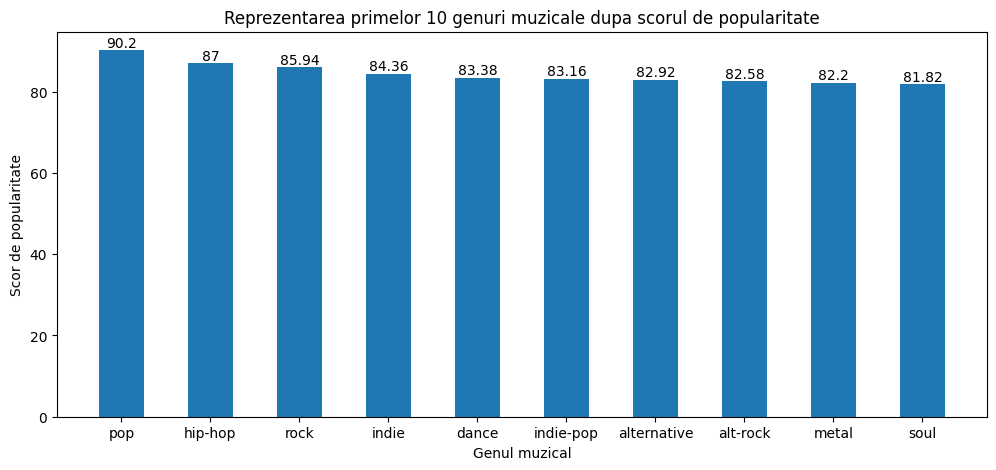

In [ ]:
plt.figure(figsize=(12, 5))
bar=plt.bar(data_to_plot_bar_chart_top10.rdd.map(lambda x: x["Genre"]).collect(),data_to_plot_bar_chart_top10.rdd.map(lambda x: x["avg(PopularityScore)"]).collect(),width=0.5)
plt.bar_label(container=bar)
plt.ylabel("Scor de popularitate")
plt.xlabel("Genul muzical")
plt.title("Reprezentarea primelor 10 genuri muzicale dupa scorul de popularitate")
plt.show()


## Afisarea ultimelor 10 genuri muzicale dupa scorul mediu de popularitate

In [ ]:
data_to_plot_bar_chart_last10=data_to_plot_bar_chart.orderBy(data_to_plot_bar_chart["avg(PopularityScore)"].desc()).toPandas().tail(10)

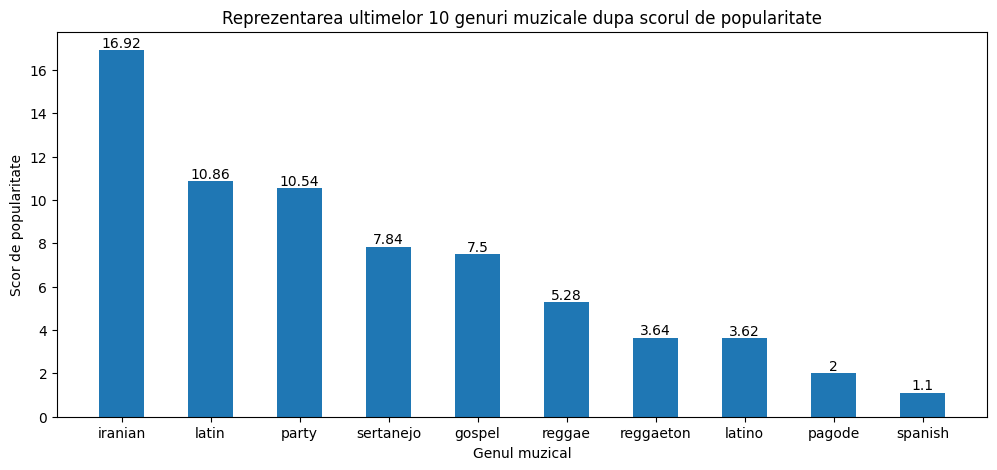

In [ ]:
plt.figure(figsize=(12, 5))
bar=plt.bar(data_to_plot_bar_chart_last10["Genre"].tolist(),data_to_plot_bar_chart_last10["avg(PopularityScore)"].tolist(),width=0.5)
plt.bar_label(container=bar)
plt.ylabel("Scor de popularitate")
plt.xlabel("Genul muzical")
plt.title("Reprezentarea ultimelor 10 genuri muzicale dupa scorul de popularitate")
plt.show()

## Identificarea celei mai populare piese pentru fiecare gen muzical din toate timpurile

In [ ]:
data_BestTrackByGenre=spotify_data.groupBy(spotify_data.Genre).agg(max_by(col=spotify_data.TrackName,ord=spotify_data.PopularityScore),max_by(col=spotify_data.Artistname,ord=spotify_data.PopularityScore),max_by(col=spotify_data.ReleaseYear,ord=spotify_data.PopularityScore),max(spotify_data.PopularityScore))

In [ ]:
data_BestTrackByGenre.show()

+-------------+----------------------------------+-----------------------------------+------------------------------------+--------------------+
|        Genre|max_by(TrackName, PopularityScore)|max_by(Artistname, PopularityScore)|max_by(ReleaseYear, PopularityScore)|max(PopularityScore)|
+-------------+----------------------------------+-----------------------------------+------------------------------------+--------------------+
|     acoustic|                           Hold On|                   Chord Overstreet|                                2017|                  82|
|     afrobeat|              Calm Down (with S...|                               Rema|                                2022|                  89|
|     alt-rock|                   Sweater Weather|                  The Neighbourhood|                                2013|                  92|
|  alternative|                   Sweater Weather|                  The Neighbourhood|                                2013|       

## Identificarea primelor 5 cele mai populare piese indiferent de genul muzical

In [ ]:
data_BestTrackByGenre=data_BestTrackByGenre.withColumn("max(PopularityScore)",data_BestTrackByGenre["max(PopularityScore)"].cast('int'))
data_BestTrackByGenre.select("*").orderBy(data_BestTrackByGenre["max(PopularityScore)"].desc()).limit(5).show()

+----------+----------------------------------+-----------------------------------+------------------------------------+--------------------+
|     Genre|max_by(TrackName, PopularityScore)|max_by(Artistname, PopularityScore)|max_by(ReleaseYear, PopularityScore)|max(PopularityScore)|
+----------+----------------------------------+-----------------------------------+------------------------------------+--------------------+
|     dance|              All I Want for Ch...|                       Mariah Carey|                                1994|                 100|
|       pop|              All I Want for Ch...|                       Mariah Carey|                                1994|                 100|
|     indie|              My Love Mine All ...|                             Mitski|                                2023|                  98|
|      rock|              Rockin' Around Th...|                         Brenda Lee|                                1964|                  98|
|rocka

In [ ]:
data_BestTrackByGenre.select("*").where(data_BestTrackByGenre.Genre=="hip-hop").show()

+-------+----------------------------------+-----------------------------------+------------------------------------+--------------------+
|  Genre|max_by(TrackName, PopularityScore)|max_by(Artistname, PopularityScore)|max_by(ReleaseYear, PopularityScore)|max(PopularityScore)|
+-------+----------------------------------+-----------------------------------+------------------------------------+--------------------+
|hip-hop|                       Lovin On Me|                        Jack Harlow|                                2023|                  97|
+-------+----------------------------------+-----------------------------------+------------------------------------+--------------------+



In [ ]:
data_BestTrackByGenre.select("*").where(data_BestTrackByGenre.Genre=="metal").show()

+-----+----------------------------------+-----------------------------------+------------------------------------+--------------------+
|Genre|max_by(TrackName, PopularityScore)|max_by(Artistname, PopularityScore)|max_by(ReleaseYear, PopularityScore)|max(PopularityScore)|
+-----+----------------------------------+-----------------------------------+------------------------------------+--------------------+
|metal|                        In the End|                        Linkin Park|                                2000|                  89|
+-----+----------------------------------+-----------------------------------+------------------------------------+--------------------+



## Analiza evolutiei scorului de popularitate a fiecarui gen muzical dupa anul de lansare al pieselor

In [ ]:
data_ReleaseYears=spotify_data.groupBy(spotify_data.ReleaseYear,spotify_data.Genre).agg(avg(spotify_data.PopularityScore)).sort(spotify_data.ReleaseYear.asc())

In [ ]:
data_ReleaseYears.show()

+-----------+-----------+--------------------+
|ReleaseYear|      Genre|avg(PopularityScore)|
+-----------+-----------+--------------------+
|       1912|      tango|                44.0|
|       1931|      tango|                50.0|
|       1941| honky-tonk|                44.0|
|       1944|       jazz|                82.0|
|       1947|    country|                85.0|
|       1949|  classical|                72.0|
|       1950| honky-tonk|                45.0|
|       1951| honky-tonk|                47.0|
|       1952| honky-tonk|               46.25|
|       1953| honky-tonk|                49.6|
|       1954| honky-tonk|  45.333333333333336|
|       1955|  bluegrass|                59.0|
|       1955| honky-tonk|                46.0|
|       1957|       rock|                89.0|
|       1957| rockabilly|                81.5|
|       1957|rock-n-roll|                81.5|
|       1958|   acoustic|                63.0|
|       1959| rockabilly|                78.0|
|       1959|

In [ ]:
spotify_data.select("*").filter("Genre == 'hip-hop' AND ReleaseYear==2000").show()

+--------------------+-------------------+----------+---------------+-----------+-------+
|             TrackId|          TrackName|Artistname|PopularityScore|ReleaseYear|  Genre|
+--------------------+-------------------+----------+---------------+-----------+-------+
|3UmaczJpikHgJFyBT...|               Stan|    Eminem|             85|       2000|hip-hop|
|3yfqSUWxFvZELEM4P...|The Real Slim Shady|    Eminem|             90|       2000|hip-hop|
+--------------------+-------------------+----------+---------------+-----------+-------+



In [ ]:
data_ReleaseYears.select("*").where(data_ReleaseYears['Genre']=="hip-hop").show()

+-----------+-------+--------------------+
|ReleaseYear|  Genre|avg(PopularityScore)|
+-----------+-------+--------------------+
|       2000|hip-hop|                87.5|
|       2002|hip-hop|   88.33333333333333|
|       2003|hip-hop|   82.66666666666667|
|       2004|hip-hop|                85.0|
|       2005|hip-hop|                84.5|
|       2007|hip-hop|   87.33333333333333|
|       2008|hip-hop|                89.0|
|       2010|hip-hop|                88.0|
|       2011|hip-hop|   84.66666666666667|
|       2012|hip-hop|                84.0|
|       2013|hip-hop|                87.0|
|       2014|hip-hop|                88.5|
|       2016|hip-hop|                88.5|
|       2017|hip-hop|   87.66666666666667|
|       2018|hip-hop|                86.0|
|       2019|hip-hop|                79.0|
|       2020|hip-hop|                89.0|
|       2021|hip-hop|                89.0|
|       2022|hip-hop|                85.5|
|       2023|hip-hop|              90.375|
+----------

## Afisarea evolutiei scorului de popularitate pentru primele 3 genuri muzicale ca popularitate dupa anul de lansare al pieselor

In [ ]:
for genre in ["hip-hop","pop","rock"]:
  data_ReleaseYears_buffer=data_ReleaseYears.select("*").where(data_ReleaseYears.Genre==genre).toPandas()
  plt.figure(figsize=(15,10))
  plt.plot(data_ReleaseYears_buffer["ReleaseYear"].tolist(),data_ReleaseYears_buffer["avg(PopularityScore)"].tolist())
  plt.xlabel("Ani lansare piese")
  plt.ylabel("Scor popularitate")
  plt.title("Reprezentarea evolutiei scorului de popularitate al pieselor dupa anul lansarii pentru genul muzical "+genre)
  plt.savefig("/content/Grafice_evolutie_popularitate_dupa_gen/Reprezentarea evolutiei scorului de popularitate al pieselor dupa anul lansarii pentru genul muzical "+genre)
  plt.close()

## Calcularea numarului de piese dupa gen pe anul de lansare

---



In [ ]:
data_tracks_count_by_genre=spotify_data.groupBy(spotify_data.ReleaseYear,spotify_data.Genre).agg(count(spotify_data.Genre))
data_tracks_count_by_genre.show()

+-----------+-----------------+------------+
|ReleaseYear|            Genre|count(Genre)|
+-----------+-----------------+------------+
|       1996|       industrial|           2|
|       2008|        bluegrass|           4|
|       2014|             club|           3|
|       2019|          british|           1|
|       2005|           french|           1|
|       2012|         acoustic|           1|
|       2023|           pagode|          49|
|       1999|           trance|           2|
|       2010|          country|           1|
|       2011|            j-pop|           9|
|       2020|            chill|           4|
|       2017|            samba|           1|
|       1984|singer-songwriter|           2|
|       1997|          turkish|           1|
|       2013|              pop|           3|
|       1997|         trip-hop|           1|
|       2017|              sad|           1|
|       2019|           german|           4|
|       2022|        indie-pop|           7|
|       20

## Afisarea primelor 10 genuri muzicale dupa numarului de piese lansate in anii 2019, 2020, 2021, 2022 ( ce piese au fost lansate inainte, in timpul si dupa pandemie)

In [ ]:
years=[2019,2020,2021,2022,2023]
for year in years:
    data_to_plot_bar_chart_no_tracks_top10=data_tracks_count_by_genre.select("*").where(data_tracks_count_by_genre.ReleaseYear==str(year)).orderBy(data_tracks_count_by_genre['count(Genre)'].cast("int").desc()).limit(10)
    plt.figure(figsize=(12,5))
    bar=plt.bar(data_to_plot_bar_chart_no_tracks_top10.rdd.map(lambda x: x["Genre"]).collect(),data_to_plot_bar_chart_no_tracks_top10.rdd.map(lambda x: x["count(Genre)"]).collect(),width=0.5)
    plt.bar_label(container=bar)
    plt.ylabel("Numar piese lansate in anul "+str(year))
    plt.xlabel("Genul muzical")
    plt.title("Reprezentarea primelor 10 genuri muzicale dupa numarului de piese lansate in anul "+str(year))
    plt.savefig("/content/Grafice_numar_piese_dupa_gen_dupa_an_lansare/Reprezentarea primelor 10 genuri muzicale dupa numarului de piese lansate in anul "+str(year))
    plt.close()

## Afisarea ultimelor 10 genuri muzicale dupa numarului de piese lansate in anii 2019, 2020, 2021, 2022 ( ce piese au fost lansate inainte, in timpul si dupa pandemie)

In [ ]:
years=[2019,2020,2021,2022,2023]
for year in years:
  data_to_plot_bar_chart_no_tracks_last10=data_tracks_count_by_genre.select("*").where(data_tracks_count_by_genre.ReleaseYear==str(year)).orderBy(data_tracks_count_by_genre['count(Genre)'].cast("int").desc()).toPandas().tail(10)
  plt.figure(figsize=(12,5))
  bar=plt.bar(data_to_plot_bar_chart_no_tracks_last10["Genre"].tolist(),data_to_plot_bar_chart_no_tracks_last10["count(Genre)"].tolist(),width=0.5)
  plt.bar_label(container=bar)
  plt.ylabel("Numar piese lansate in anul "+str(year))
  plt.xlabel("Genul muzical")
  plt.title("Reprezentarea ultimelor 10 genuri muzicale dupa numarului de piese lansate in anul "+str(year))
  plt.savefig("/content/Grafice_numar_piese_dupa_gen_dupa_an_lansare/Reprezentarea ultimelor 10 genuri muzicale dupa numarului de piese lansate in anul "+str(year))
  plt.close()


## Inchiderea sesiunii in PySpark

In [ ]:
spark.stop()